In [1]:
# run_notebook.py
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
import sys

def run_entire_notebook(notebook_path):
    with open(notebook_path, "r") as f:
        notebook_content = f.read()

    notebook = nbformat.reads(notebook_content, as_version=4)
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(notebook, {"metadata": {"path": "./"}})

    # Save the notebook after execution to retain the outputs
    with open(notebook_path, "w") as f:
        nbformat.write(notebook, f)

# Execute the function when this script is run
notebook_path = sys.argv[1]
run_entire_notebook(notebook_path)



FileNotFoundError: [Errno 2] No such file or directory: '-f'

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install shapely
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install firebase-admin
!pip install google-cloud-storage

print("Install complete.")



Install complete.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString
from os import listdir
from os.path import isfile, join
import os.path
import google.cloud.storage as gcs
import firebase_admin
from firebase_admin import credentials, firestore, storage

def download_and_read_logs(model_name):
    bucket_name = 'deepracer-52ec7.appspot.com'
    #storage_client = storage.Client.from_service_account_json('path_to_service_account.json')
    bucket = storage.bucket(bucket_name)

     #Dynamic log file names
    robomaker_log = f'{model_name}-robomakerLog.log'
    sagemaker_log = f'{model_name}-sagemakerLog.log'

    try:
        # Download robomaker log
        robomaker_blob = bucket.blob(f'Trainingfiles/{robomaker_log}')
        robomaker_blob.download_to_filename(f'tmp_{robomaker_log}')
        
        # Download sagemaker log
        sagemaker_blob = bucket.blob(f'Trainingfiles/{sagemaker_log}')
        sagemaker_blob.download_to_filename(f'tmp_{sagemaker_log}')
        
        # Process the downloaded logs as needed

    except Exception as e:
        # Print or handle the exception here
        print(f"Error: {e}")


if not firebase_admin._apps:
    cred = credentials.Certificate("deepracer-52ec7-firebase-adminsdk-z1mqa-0560f04062.json")
    firebase_admin.initialize_app(cred, {'storageBucket': bucket_name})
else:
    print("Firebase app already initialized.")

db = firestore.client()

# Obtain model_name dynamically from frontend input
# model_name = get_model_name_from_frontend()   # Implement this function based on your frontend logic
model_name = "exampleName"  # Placeholder for demonstration
download_and_read_logs(model_name)

doc_ref = db.collection('test_collection').add({'status': 'connected'})
doc = db.collection('test_collection').document(doc_ref[1].id).get()
print('Firestore Connection Status:', doc.to_dict()['status'])

print(f'Trying to access: Trainingfiles/{model_name}-robomakerLog.log')


Firebase app already initialized.
Error: 404 GET https://storage.googleapis.com/download/storage/v1/b/deepracer-52ec7.appspot.com/o/Trainingfiles%2FexampleName-robomakerLog.log?alt=media: No such object: deepracer-52ec7.appspot.com/Trainingfiles/exampleName-robomakerLog.log: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)
Firestore Connection Status: connected
Trying to access: Trainingfiles/exampleName-robomakerLog.log


In [31]:
# define Training Parameters


def robomaker_training_parameters(robomaker_log, training_parameters):
    parameters = {}
    
    with open(robomaker_log, 'r') as file:
        for line in file:
            if line.startswith("PARAMETERS"):
                break
                
        for line in file:
            if line.strip() == "":
                break
                
            try:
                parts = line.strip().split(": ")
                key = parts[0].strip(" *")
                if key in training_parameters:
                    parameters[key] = parts[1]
            except ValueError:
                continue
                
    return parameters
    #Retrieve

training_parameters_to_extract = [
    '/AWS_REGION', 
    '/WORLD_NAME', 
    '/SIMTRACE_S3_PREFIX', 
    '/MODEL_NAME',
    '/RACE_TYPE'
]

json_parameters = robomaker_training_parameters(robomaker_log, training_parameters_to_extract)

print(f"AWS_REGION: {json_parameters.get('/AWS_REGION', ' ')}")
print(f"WORLD_NAME: {json_parameters.get('/WORLD_NAME', ' ')}")
print(f"SIMTRACE_S3_PREFIX: {json_parameters.get('/SIMTRACE_S3_PREFIX', ' ')}")
print(f"MODEL_NAME: {json_parameters.get('/MODEL_NAME', ' ')}")
print(f"RACE_TYPE: {json_parameters.get('/RACE_TYPE', ' ')}")


AWS_REGION: us-east-1
WORLD_NAME: reInvent2019_track_cw
SIMTRACE_S3_PREFIX: data-7ce4dca5-5c5...
MODEL_NAME: Baris-Model
RACE_TYPE: TIME_TRIAL


In [32]:
model_name = json_parameters.get('/MODEL_NAME', 'default_collection')
doc_ref = db.collection(model_name).add({'status': 'connected'})

In [33]:
 #define Hyperparameters

def robomaker_hyperparameters(robomaker_log, hyperparameter_data):
    hyperparameters = {}
    
    with open(robomaker_log, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith("Using the following hyper-parameters"):
            start_index = i + 1
        elif start_index is not None and line.strip() == "}":
            end_index = i
            break

    if start_index is None or end_index is None:
        return hyperparameters
    
    json_block = "".join(lines[start_index:end_index+1]).strip()
    
    try:
        all_hyperparameters = json.loads(json_block)
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
        return hyperparameters
    
    for key in hyperparameter_data:
        hyperparameters[key] = all_hyperparameters.get(key, None)
    
    return hyperparameters

# Retrieve Hyperparameters

#EPI= episodes per iteration
hyperparameters = robomaker_hyperparameters(robomaker_log, ['num_episodes_between_training', 'num_epochs'])
EPI = int(hyperparameters.get('num_episodes_between_training', 0))
NUM_Epochs = int(hyperparameters.get('num_epochs', 0))

print('hyperparameters: %s' % hyperparameters)
print('EPI: %s' % EPI)
print('NUM_Epochs: %s' % NUM_Epochs)


#hyperparameter_data_to_extract = [
  #  "batch_size", 
 #   "num_episodes_between_training", 
  #  "num_epochs"
#]



#json_parameters = robomaker_hyperparameters(robomaker_log, hyperparameter_data_to_extract)
#
#print(f"Batch Size: {json_parameters.get('batch_size', ' ')}")
#print(f"Number of episodes: {json_parameters.get('num_episodes_between_training', ' ')}")
#print(f"Number of epochs: {json_parameters.get('num_epochs', ' ')}")

hyperparameters: {'num_episodes_between_training': 15, 'num_epochs': 5}
EPI: 15
NUM_Epochs: 5


In [34]:



def robomaker_action_space(robomaker_log):
    with open(robomaker_log, 'r') as file:
        for line in file:
            if "Action space from file:" in line:
                action_space_str = line.split("Action space from file:")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'simple'
                
            if "Reward Distribution Graph:  racecar" in line:
                action_space_str = line.split("Reward Distribution Graph:  racecar")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'advanced'
                
    print("Warning: No action space found.")
    return None, None

def display_action_space(action_space_data):
    if action_space_data is None:
        print("No action space data available.")
        return None
    
    # Check for 'index' to distinguish between Advanced and Simple Machines
    if all('index' in action for action in action_space_data):
        action_names = []
        for action in action_space_data:
            action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
            action_speed = ('SPD:%.2f' % action['speed'])
            action_names.append(action_steering + ' / ' + action_speed)
        return action_names
    
    else:  # For Simple Machines
        print("High:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['high']}")
        
        print("\nLow:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['low']}")
        return None


# Retrieve action space
action_space_data, machine_type = robomaker_action_space(robomaker_log)


# Display action space
result = display_action_space(action_space_data)
if result:
    for action in result:
        print(action)



RIGHT:30.0 / SPD:0.33
RIGHT:30.0 / SPD:0.67
RIGHT:30.0 / SPD:1.00
RIGHT:20.0 / SPD:0.33
RIGHT:20.0 / SPD:0.67
RIGHT:20.0 / SPD:1.00
RIGHT:10.0 / SPD:0.33
RIGHT:10.0 / SPD:0.67
RIGHT:10.0 / SPD:1.00
CENTER:0.0 / SPD:0.33
CENTER:0.0 / SPD:0.67
CENTER:0.0 / SPD:1.00
LEFT:10.0 / SPD:0.33
LEFT:10.0 / SPD:0.67
LEFT:10.0 / SPD:1.00
LEFT:20.0 / SPD:0.33
LEFT:20.0 / SPD:0.67
LEFT:20.0 / SPD:1.00
LEFT:30.0 / SPD:0.33
LEFT:30.0 / SPD:0.67
LEFT:30.0 / SPD:1.00


In [35]:
def display_action_space_info(action_space_data):
    speeds = [entry['speed'] for entry in action_space_data]
    angles = [entry['steering_angle'] for entry in action_space_data]
        
    print("SPEED:", speeds)
    print("STEERING:", angles)
    print("MIN SPEED:", min(speeds))
    print("MAX SPEED:", max(speeds))
    print("MIN STEERING:", min(angles))
    print("MAX STEERING:", max(angles))
    print("SPEED RANGE:", max(speeds) - min(speeds))
    print("STEERING RANGE:", max(angles) - min(angles))

# Usage example
action_space_data, machine_type = robomaker_action_space(robomaker_log)
if action_space_data:
    display_action_space_info(action_space_data)
else:
    print("Failed to load action space data.")



SPEED: [0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0]
STEERING: [-30.0, -30.0, -30.0, -20.0, -20.0, -20.0, -10.000000000000004, -10.000000000000004, -10.000000000000004, 0.0, 0.0, 0.0, 9.999999999999998, 9.999999999999998, 9.999999999999998, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0]
MIN SPEED: 0.3333333333333333
MAX SPEED: 1.0
MIN STEERING: -30.0
MAX STEERING: 30.0
SPEED RANGE: 0.6666666666666667
STEERING RANGE: 60.0


In [36]:
# Initialize list to store SIM_TRACE_LOG lines
sim_trace_logs = []

# Read the log file line by line
with open(robomaker_log, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            p = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_trace_logs.append(",".join(p))
            #sim_trace_logs.append(line.strip())  # Add line to the list after stripping newline characters

# Now you have the SIM_TRACE_LOG lines in the list `sim_trace_logs`
if sim_trace_logs:
    print("SIM_TRACE_LOG loded")
else:
    print(" SIM_TRACE_LOG data not found.")


SIM_TRACE_LOG loded


In [37]:
import pandas as pd

#raw sim table
# Reading the log file

df_list = list()

for t in sim_trace_logs[2:]:
    p = t.rstrip().split(",")
    episode = int(p[0])
    steps = int(p[1])
    x = 100*float(p[2])
    y = 100*float(p[3])
    yaw = float(p[4])
    steer = float(p[5])
    speed = float(p[6])
    action = float(p[7])
    reward = float(p[8])
    done = 0 if 'False' in p[9] else 1
    progress = float(p[11])
    closest_checkpoint = int(p[12])
    length = float(p[13])
    timestamp = float(p[14])
    stat = p[15]
    











    iteration = int(episode / EPI) + 1
    if (iteration ==1) and (episode ==0):
        steps -= 2
    episode_in_iteration = (episode % EPI) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, speed, action, reward, done, progress, closest_checkpoint, length, timestamp,  stat))
header = ['iteration', 'EPI(now working)', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'speed', 'action', 'reward', 'done', 'progress', 'closest_checkpoint', 'length', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df
    





,iteration,EPI(now working),episode,steps,x,y,yaw,steer,speed,action,reward,done,progress,closest_checkpoint,length,timestamp,status
0,1,1,1,1,-402.71,-12.00,94.3815,10.0,0.67,13.0,1.000,0,0.6665,1,23.09,17.461,in_progress
1,1,1,1,2,-403.56,-9.86,96.0712,-30.0,0.33,0.0,1.000,0,0.7555,1,23.09,17.517,in_progress
2,1,1,1,3,-403.40,-7.31,95.1234,30.0,0.67,19.0,1.000,0,0.8660,2,23.09,17.594,in_progress
3,1,1,1,4,-403.77,-4.40,95.4515,-10.0,0.67,7.0,1.000,0,0.9901,2,23.09,17.666,in_progress
4,1,1,1,5,-405.29,-0.99,98.3571,0.0,0.67,10.0,1.000,0,1.1318,2,23.09,17.724,in_progress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25745,17,15,255,290,48.95,73.57,-3.6907,30.0,0.33,18.0,0.001,0,51.6408,18,23.09,2699.004,in_progress
25746,17,15,255,291,51.22,73.54,-3.5086,10.0,0.67,13.0,0.001,0,51.6878,18,23.09,2699.063,in_progress
25747,17,15,255,292,53.79,74.14,-1.6693,0.0,0.33,9.0,0.001,0,51.7655,18,23.09,2699.129,in_progress
25748,17,15,255,293,56.51,74.37,-0.9211,20.0,0.33,15.0,0.001,0,51.8325,18,23.09,2699.203,in_progress


In [38]:
#episode data

episode_sim_df = sim_df[sim_df["done"] == 1][["iteration", "EPI(now working)", "episode", "steps", "progress", "status"]].copy()
episode_sim_df["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
episode_sim_df["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")



episode_sim_df


,iteration,EPI(now working),episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
38,1,1,1,39,5.8247,off_track,21.607,2.535,17.461,19.996
76,1,2,2,38,6.0895,off_track,20.306,2.484,20.101,22.585
153,1,3,3,77,13.7300,off_track,29.107,5.066,22.727,27.793
185,1,4,4,32,4.4687,off_track,13.907,2.046,27.930,29.976
214,1,5,5,29,4.0625,off_track,12.206,1.900,30.093,31.993
...,...,...,...,...,...,...,...,...,...,...
24338,17,11,251,395,72.9302,off_track,331.807,26.280,2578.660,2604.940
24852,17,12,252,514,100.0000,lap_complete,436.100,34.193,2605.081,2639.274
25384,17,13,253,532,100.0000,lap_complete,438.600,35.405,2639.402,2674.807
25455,17,14,254,71,11.8982,off_track,47.307,4.676,2674.927,2679.603


In [39]:
#iteration-related data

 

iteration_sim_df = episode_sim_df[episode_sim_df["EPI(now working)"] == 1][["iteration"]].copy()
iteration_sim_df["min_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("min")
iteration_sim_df["max_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("max")
iteration_sim_df["avg_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("mean")
iteration_sim_df["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
iteration_sim_df["start_time"] = episode_sim_df.groupby("iteration")["start_time"].transform("min")
iteration_sim_df["end_time"] = episode_sim_df.groupby("iteration")["end_time"].transform("max")

iteration_sim_df


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time
38,1,4.0625,18.2134,8.466633,362.916,17.461,69.862
820,2,2.6698,11.9964,6.835053,320.615,82.124,127.925
1558,3,2.9302,18.8329,7.188093,332.315,135.937,182.796
2179,4,3.7207,16.8793,8.848473,354.550,191.856,244.806
2947,5,3.0628,11.7892,6.496900,286.511,256.932,299.796
3613,6,2.3276,20.4121,8.687787,361.522,318.532,370.736
4369,7,2.8145,11.6264,7.366033,335.316,383.934,430.936
5043,8,2.8512,24.9635,9.368527,363.332,439.347,494.745
5893,9,2.9115,42.8355,12.974793,617.115,503.796,578.736
7008,10,2.9302,30.2342,11.230987,551.025,587.595,657.200


In [40]:
!pip install scikit-learn

In [41]:
from sklearn.preprocessing import MinMaxScaler

x = iteration_sim_df[['total_rewards']].values.astype(float)
if len(x) > 0:  # Missing parenthesis fixed
    min_max_scaler = MinMaxScaler(feature_range=(5, 95))
    x_scaled = min_max_scaler.fit_transform(x)
    iteration_sim_df['normalized_total_rewards'] = x_scaled

print('%d' % len(iteration_sim_df))

if len(iteration_sim_df) > 0:
    iteration_sim_df['normalized_total_rewards_SMA3'] = iteration_sim_df['normalized_total_rewards'].rolling(window=3).mean()
    iteration_sim_df['min_progress_SMA3'] = iteration_sim_df['min_progress'].rolling(window=3).mean()
    iteration_sim_df['max_progress_SMA3'] = iteration_sim_df['max_progress'].rolling(window=3).mean()
    iteration_sim_df['avg_progress_SMA3'] = iteration_sim_df['avg_progress'].rolling(window=3).mean()
    #iteration_sim_df['pct_completed_laps_SMA3'] = iteration_sim_df['pct_completed_laps'].rolling(window=3).mean()

iteration_sim_df


17


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time,normalized_total_rewards,normalized_total_rewards_SMA3,min_progress_SMA3,max_progress_SMA3,avg_progress_SMA3
38,1,4.0625,18.2134,8.466633,362.916,17.461,69.862,6.615264,NaN,NaN,NaN,NaN
820,2,2.6698,11.9964,6.835053,320.615,82.124,127.925,5.720986,NaN,NaN,NaN,NaN
1558,3,2.9302,18.8329,7.188093,332.315,135.937,182.796,5.968334,6.101528,3.220833,16.347567,7.496593
2179,4,3.7207,16.8793,8.848473,354.550,191.856,244.806,6.438400,6.042573,3.106900,15.902867,7.623873
2947,5,3.0628,11.7892,6.496900,286.511,256.932,299.796,5.000000,5.802244,3.237900,15.833800,7.511156
3613,6,2.3276,20.4121,8.687787,361.522,318.532,370.736,6.585793,6.008064,3.037033,16.360200,8.011053
4369,7,2.8145,11.6264,7.366033,335.316,383.934,430.936,6.031777,5.872524,2.734967,14.609233,7.516907
5043,8,2.8512,24.9635,9.368527,363.332,439.347,494.745,6.624058,6.413876,2.664433,19.000667,8.474116
5893,9,2.9115,42.8355,12.974793,617.115,503.796,578.736,11.989236,8.215024,2.859067,26.475133,9.903118
7008,10,2.9302,30.2342,11.230987,551.025,587.595,657.200,10.592040,9.735112,2.897633,32.677733,11.191436


In [42]:
#Amazon SageMaker) Logs
#check that SageMaker log exist

with open(sagemaker_log, 'r') as file:
      print("sagemaker log file read.")

sagemaker log file read.


In [43]:
import re

policytrn_data = []
last_iteration = 0

with open(sagemaker_log, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            match = re.search(r"Training iteration=(\d+)", line)
            if match:
                last_iteration = match.group(1)
        
        if "Policy training> " in line:
            parts = re.findall(r"([-\d.e]+)", line)
            parts = [p for p in parts if p != 'e']
            policytrn_data.append(",".join([last_iteration] + parts))

print(policytrn_data[1:20])


['0,-0.0035925842821598053,0.0010154742049053311,3.042198419570923,1,3e-05', '0,-0.016446126624941826,0.003756540594622493,3.038893461227417,2,3e-05', '0,-0.023584390059113503,0.007874511182308197,3.034268617630005,3,3e-05', '0,-0.027545146644115448,0.00945213157683611,3.032560348510742,4,3e-05', '1,0.018130237236618996,0.00016040012997109443,3.0305449962615967,0,3e-05', '1,-0.012686872854828835,0.0017990132328122854,3.029784679412842,1,3e-05', '1,-0.026721810922026634,0.005176019389182329,3.0290024280548096,2,3e-05', '1,-0.032316382974386215,0.00810375064611435,3.0293450355529785,3,3e-05', '1,-0.030834387987852097,0.010022496804594994,3.0279488563537598,4,3e-05', '2,-0.004997360520064831,0.000141054842970334,3.0290122032165527,0,3e-05', '2,-0.009806187823414803,0.0013133371248841286,3.029191732406616,1,3e-05', '2,-0.040898580104112625,0.0053224689327180386,3.025245189666748,2,3e-05', '2,-0.01584332250058651,0.011685684323310852,3.015601634979248,3,3e-05', '2,-0.00304958363994956,0.011

In [44]:
#Parse policy training data

df_list = list()

for d in policytrn_data:
    p = d.rstrip().split(",")
    iteration = int(p[0]) + 1
    #surrogate_loss = float(p[1])
    #kl_divergence = float(p[12)
    entropy = float(p[3])
    training_epoch = float(p[4])
    learning_rate = float(p[5])
    #avg_entropy = policytrn_df.groupby("iteration")["entropy"].transform("mean")

    df_list.append((iteration, entropy, training_epoch, learning_rate))


header = ['iteration', 'entropy', 'training_epoch', 'learning_rate']

policytrn_df = pd.DataFrame(df_list, columns=header)
policytrn_df
    
    
    

,iteration,entropy,training_epoch,learning_rate
0,1,3.043577,0.0,0.00003
1,1,3.042198,1.0,0.00003
2,1,3.038893,2.0,0.00003
3,1,3.034269,3.0,0.00003
4,1,3.032560,4.0,0.00003
...,...,...,...,...
78,16,2.759194,3.0,0.00003
79,16,2.763390,4.0,0.00003
80,17,2.752107,0.0,0.00003
81,17,2.755888,1.0,0.00003


In [45]:
#aggregated values for iterations

if(len(policytrn_df)>0):
    policytrn_df["avg_entropy"] = policytrn_df.groupby("iteration")["entropy"].transform("mean")
    policytrn_df_entropy = policytrn_df[policytrn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

policytrn_df_entropy['SMA3_avg_entropy'] = policytrn_df_entropy.iloc[:,1].rolling(window=3).mean()
policytrn_df_entropy
    
    

,iteration,avg_entropy,SMA3_avg_entropy
1,1,3.038300,NaN
6,2,3.029325,NaN
11,3,3.022765,3.030130
16,4,3.015775,3.022622
21,5,3.008260,3.015600
26,6,2.991323,3.005119
31,7,2.969683,2.989755
36,8,2.924457,2.961821
41,9,2.885330,2.926490
46,10,2.818567,2.876118


Number of episodes =  255
Number of complete iterations =  17


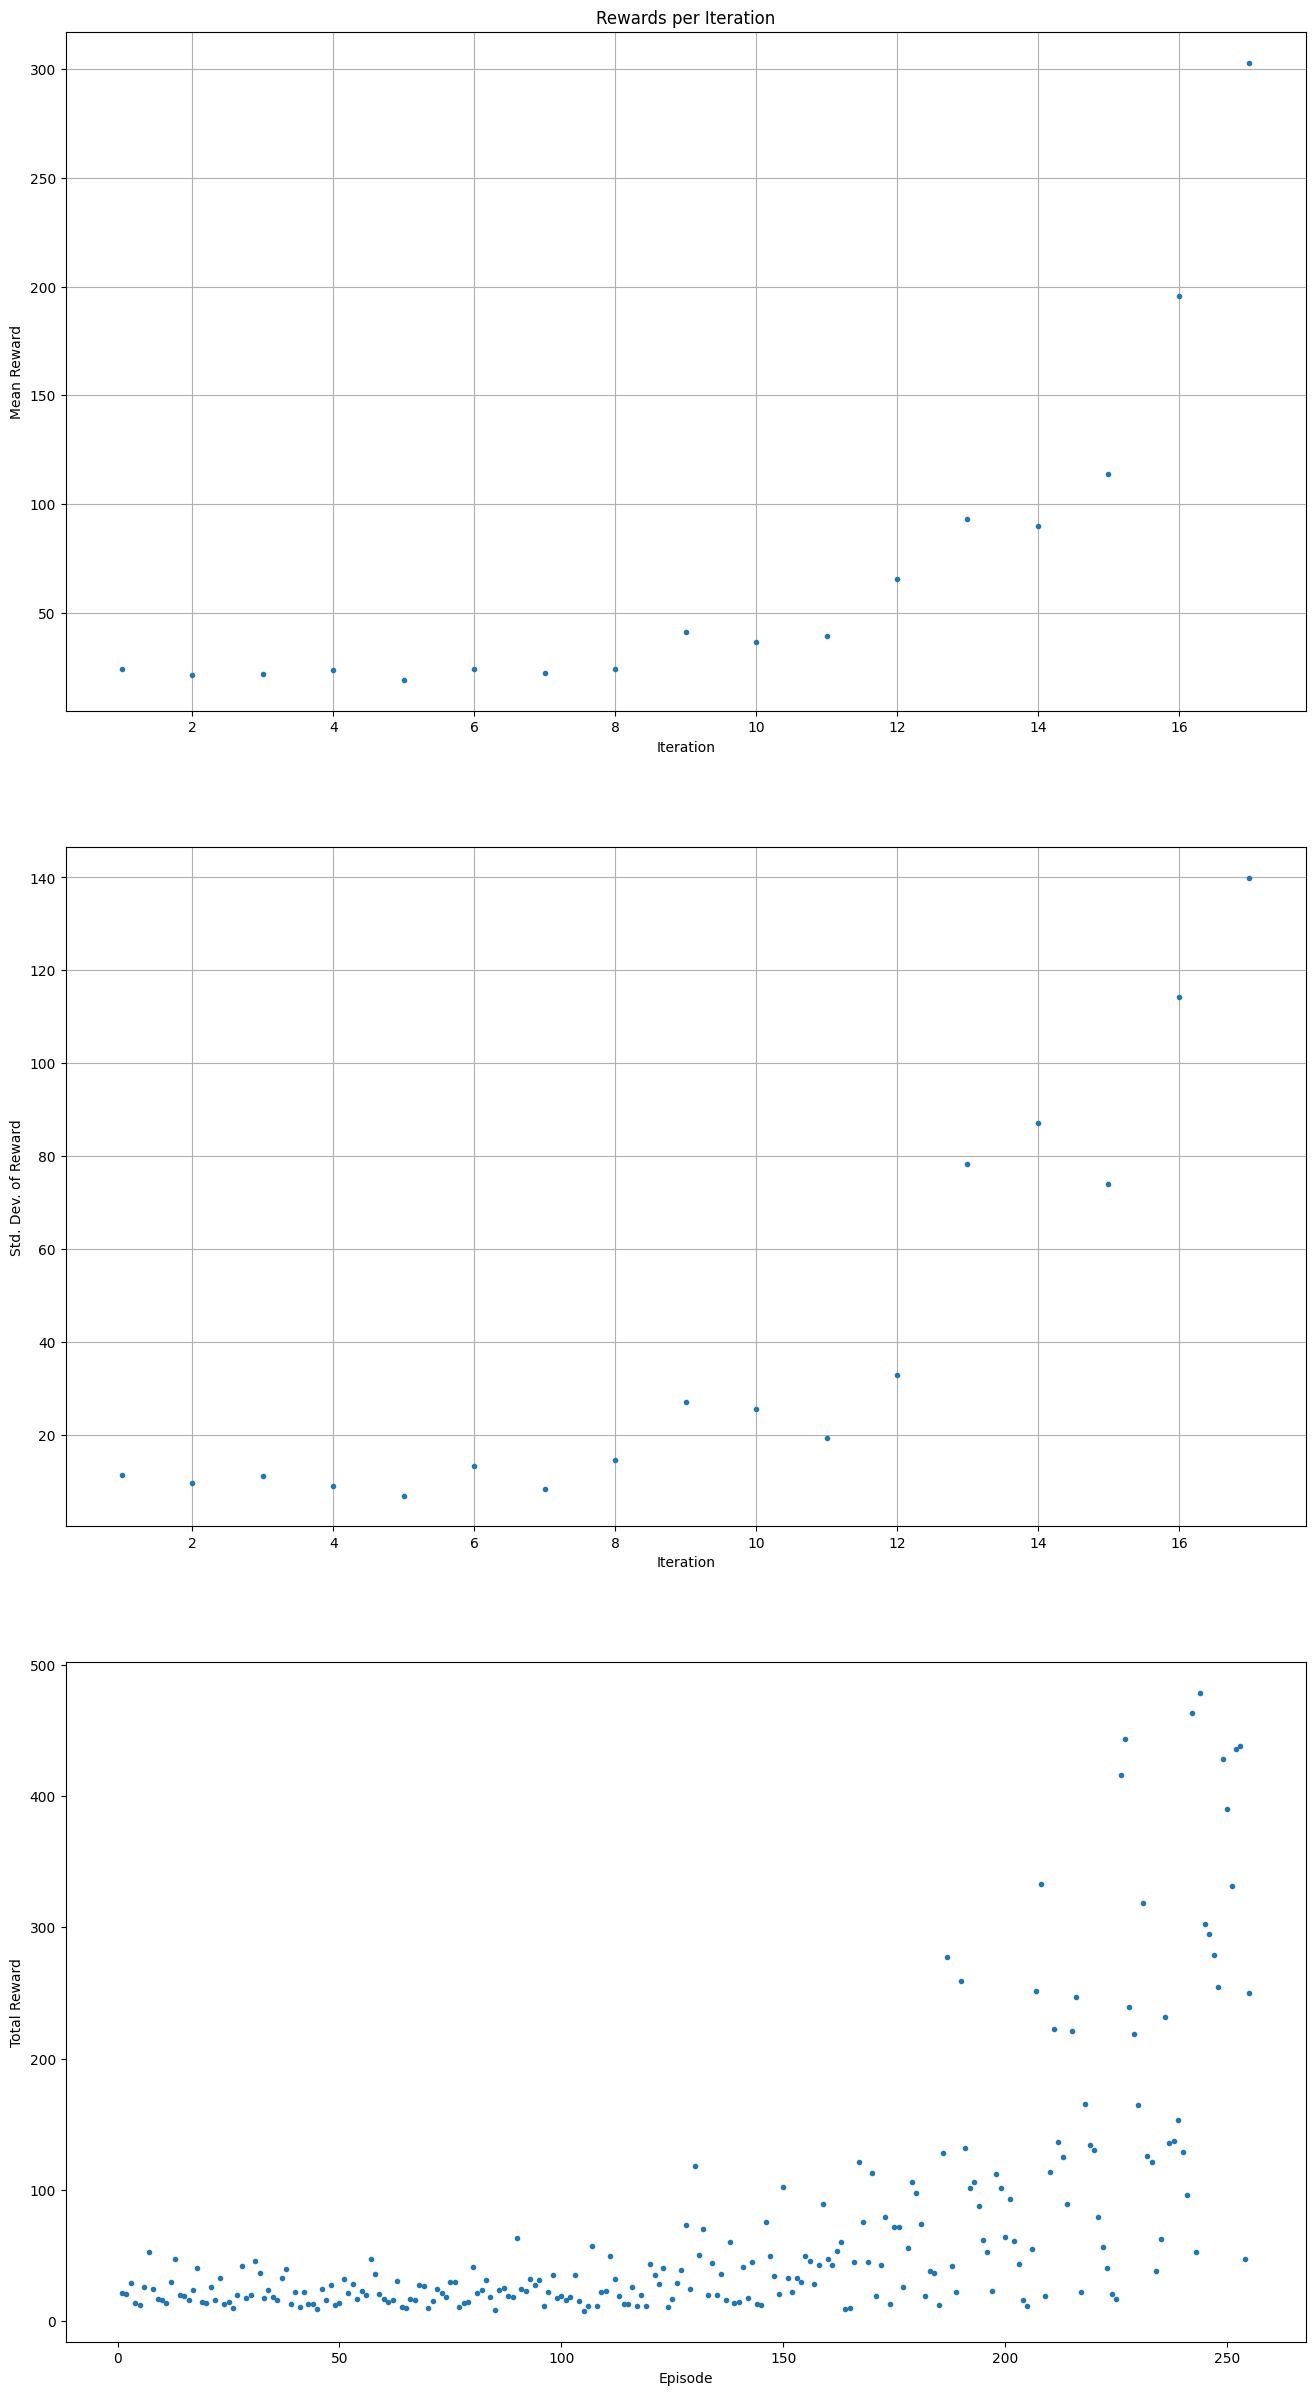

In [46]:
#Reward graph per episode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

max_ep = np.max(sim_df['episode'])
max_iteration = np.max(policytrn_df['iteration']) #tempoary fix 
print('Number of episodes = ', max_ep)
print('Number of complete iterations = ', max_iteration)


# Calculate total rewards per episode
total_rewards = sim_df.groupby('episode')['reward'].sum().values

# Calculate average and standard deviation of rewards per iteration
buffer_rew = []
average_rewards, deviation_rewards = [], []

for idx, reward in enumerate(total_rewards, 1):
    buffer_rew.append(reward)
    if idx % EPI == 0:
        average_rewards.append(np.mean(buffer_rew))
        deviation_rewards.append(np.std(buffer_rew))
        buffer_rew.clear()

#Conver to dictionary
reward_data = {
    'total_rewards': total_rewards.tolist(), 
    'average_rewards': average_rewards,
    'deviation_rewards': deviation_rewards,
}

# Upload to Firebase
model_name = json_parameters.get('/MODEL_NAME', 'default_collection')
doc_ref = db.collection(model_name).document('reward_metrics').set(reward_data)


# Create plots
fig, axes = plt.subplots(3, 1, figsize=(16, 30))

# Plot average rewards
axes[0].plot(range(1, len(average_rewards) + 1), average_rewards, '.')
axes[0].set(title='Rewards per Iteration', xlabel='Iteration', ylabel='Mean Reward')
axes[0].grid(True)

# Plot standard deviation of rewards
axes[1].plot(range(1, len(deviation_rewards) + 1), deviation_rewards, '.')
axes[1].set(ylabel='Std. Dev. of Reward', xlabel='Iteration')
axes[1].grid(True)

# Plot total rewards
axes[2].plot(range(1, len(total_rewards) + 1), total_rewards, '.')
axes[2].set(ylabel='Total Reward', xlabel='Episode')
axes[2].grid(False)

plt.show()


In [47]:
#Performance Envelope of the Model graph-to do

In [48]:
#Potential Model Checkpoints for Cloning and Race Submission-to do

In [49]:
import numpy as np
import os
import re

def find_matching_track_file(world_name):
    track_folder_path = "./Tracks"  # Assuming the folder is relative to the notebook
    for filename in os.listdir(track_folder_path):
        if world_name.lower() in filename.lower() and filename.endswith('.npy'):
            return filename
    return None

def get_track_checkpoints(track_filename):
    track_path = os.path.join("./Tracks", track_filename)
    return np.load(track_path)

def get_track_name_from_log(robomaker_log, line_number=228):
    with open(robomaker_log, 'r') as file:
        for i, line in enumerate(file, 1):
            if i == line_number:
                match = re.search(r"Topic \[(.*?)//", line)
                if match:
                    return match.group(1)
    return None



# Get track name from robomaker log
track_name = get_track_name_from_log(robomaker_log)

if track_name:
    matching_track_file = find_matching_track_file(track_name)
    if matching_track_file:
        checkpoints = get_track_checkpoints(matching_track_file)
        print(f"Found matching track file: {matching_track_file}")
        print(f"checkpoints shape: {checkpoints.shape}")
    else:
        print("No matching track file found.")
else:
    print("Track name not found in log.")


Found matching track file: reInvent2019_track_cw.npy
checkpoints shape: (79, 6)


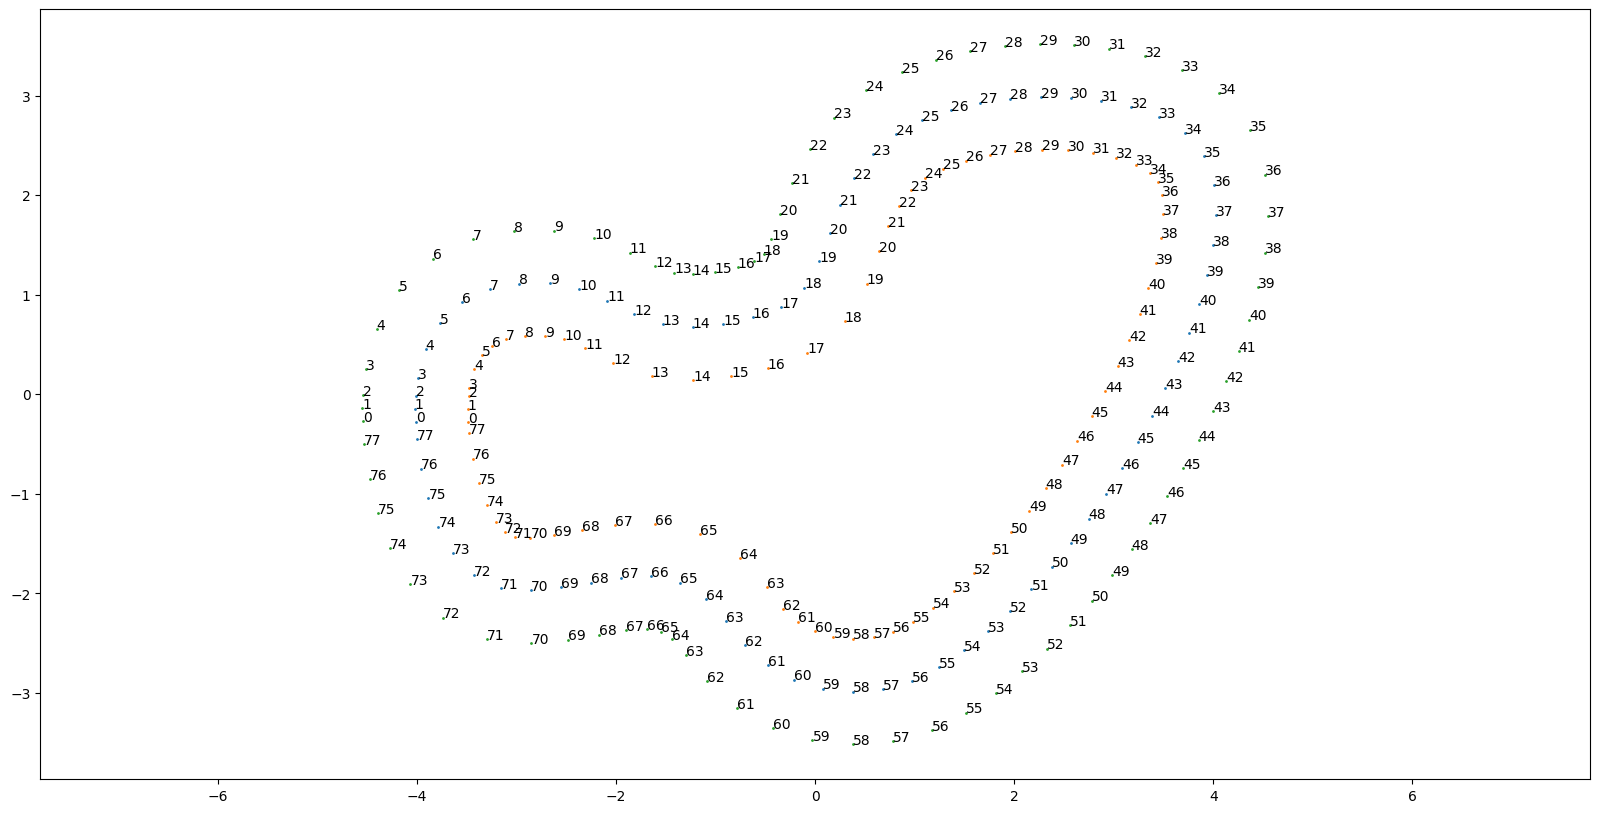

In [50]:
import matplotlib.pyplot as plt

def plot_points(ax, points):
    ax.scatter(points[:,0], points[:,1], s=1)
    for i, p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

# Plot the results
fig, ax = plt.subplots(figsize=(20, 10))
plot_points(ax, checkpoints[:-1, 0:2])
plot_points(ax, checkpoints[:-1, 2:4])
plot_points(ax, checkpoints[:-1, 4:6])
ax.axis('equal')
plt.show()


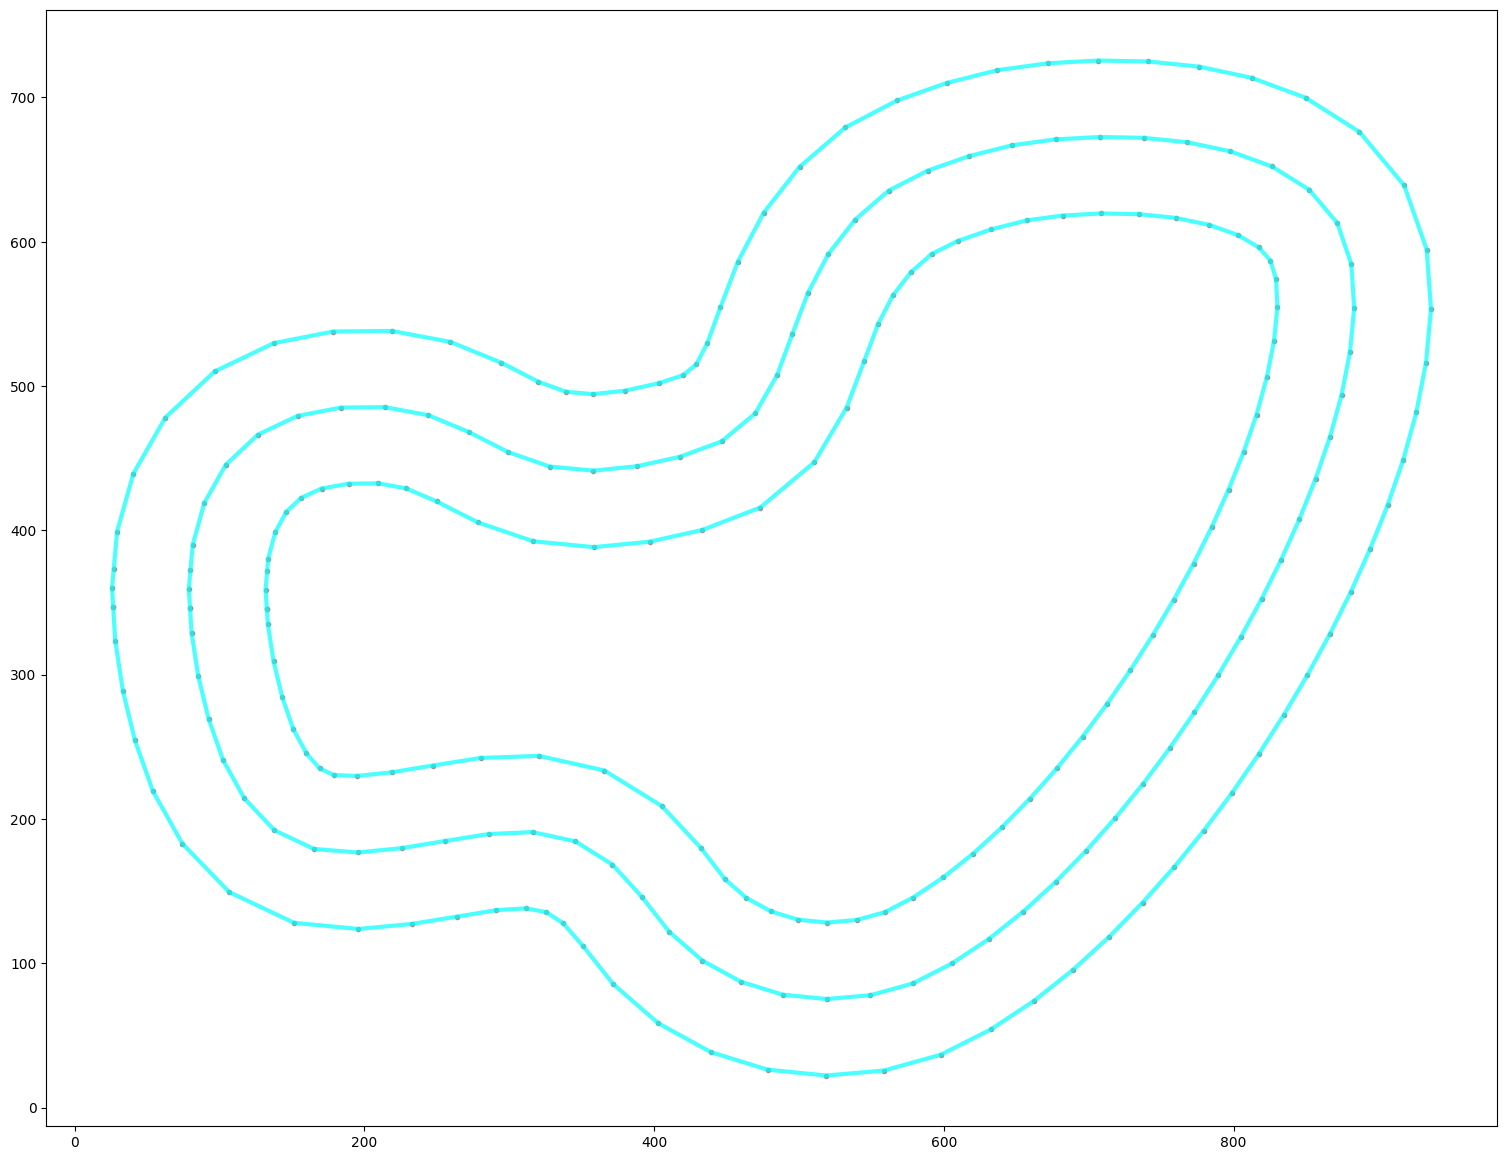

In [51]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# rescale to centimeter 
center_line = checkpoints[:, 0:2] * 100
inner_border = checkpoints[:, 2:4] * 100
outer_border = checkpoints[:, 4:6] * 100

# Adjust for x_offset and y_offset
x_offset = abs(min(0, int(sim_df['x'].min())))
y_offset = abs(min(0, int(sim_df['y'].min())))

# Add offsets 
inner_border += [x_offset, y_offset]
center_line += [x_offset, y_offset]
outer_border += [x_offset, y_offset]


def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, checkpoints, inner_border_checkpoints, outer_border_checkpoints):
    line = LineString(checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

# plot dimensions on checkpoints data
plot_x_max = int(max(np.max(outer_border[:, 0]), np.max(center_line[:, 0]), np.max(inner_border[:, 0])))
plot_y_max = int(max(np.max(outer_border[:, 1]), np.max(center_line[:, 1]), np.max(inner_border[:, 1])))

fig = plt.figure(figsize=(plot_x_max / 50, plot_y_max / 50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border)


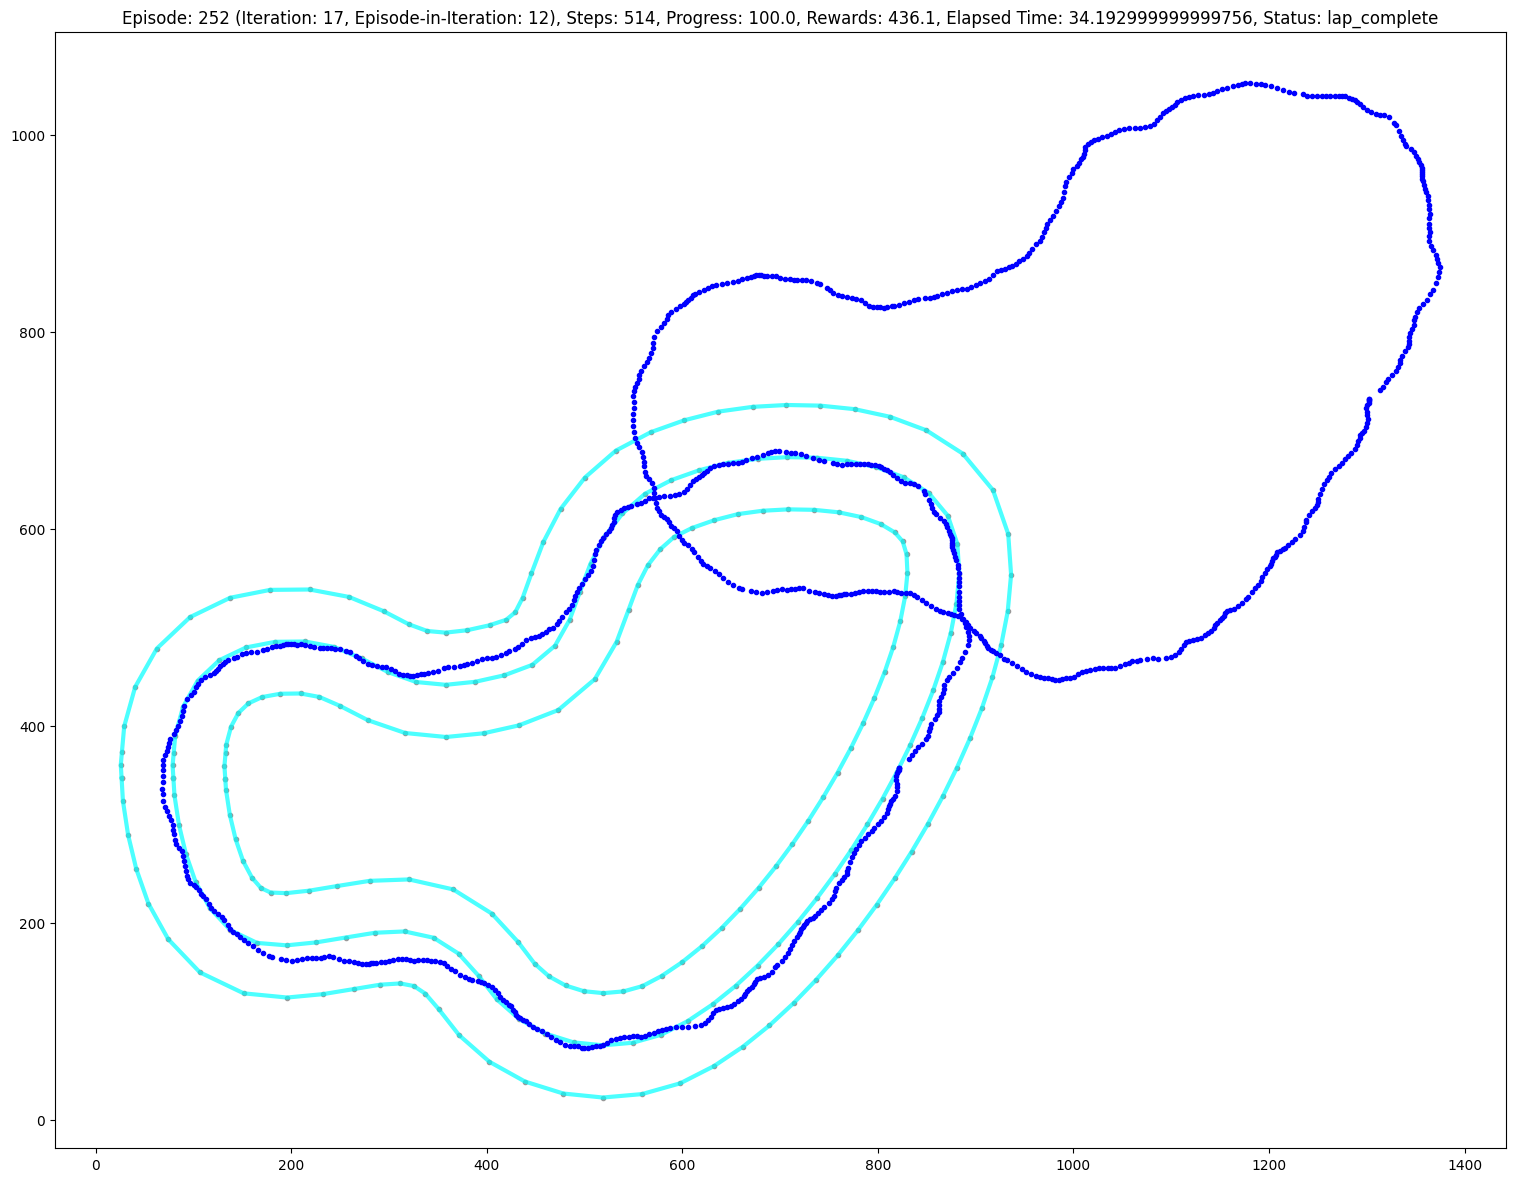

In [58]:
def plot_arrow(ax, x, y, dx, dy, color):
    ax.arrow(x, y, dx, dy, linewidth=1, head_width=8, head_length=5, fc=color, ec=color, zorder=99)

def plot_episode_info(ax, episode):
    title = f"Episode: {episode['episode']} (Iteration: {episode['iteration']}, Episode-in-Iteration: {episode['EPI(now working)']})"
    title += f", Steps: {episode['steps']}, Progress: {episode['progress']}, Rewards: {episode['episode_total_rewards']}, Elapsed Time: {episode['elapsed_time']}, Status: {episode['status']}"

    ax.set_title(title)

def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig, axes = plt.subplots(n_laps, 1, figsize=(plot_x_max/50, plot_y_max/50 * n_laps))
    if n_laps == 1:
        axes = [axes]  # Make it iterable
    for i, ax in enumerate(axes):
        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode'] == idx]
        episode_info = episode_sim_df[episode_sim_df['episode'] == idx].iloc[0]
        episode_data = episode_data.drop_duplicates(subset=['x', 'y'])

        
        plot_episode_info(ax, episode_info)
        print_border(ax, center_line, inner_border, outer_border)
        
        for _, row in episode_data.iterrows():
            x, y = row['x'] + x_offset, row['y'] + y_offset
            ax.plot([x, x-0.02+x_offset], [y, y+y_offset], 'b.')
            
            if plot_yaw:
                dx = 5 * row['speed'] * math.cos(math.radians(row['yaw']))
                dy = 5 * row['speed'] * math.sin(math.radians(row['yaw']))
                plot_arrow(ax, x, y, dx, dy, 'b')
            
            if plot_steer:
                dx = 5 * row['speed'] * math.cos(math.radians(row['yaw'] + row['steer']))
                dy = 5 * row['speed'] * math.sin(math.radians(row['yaw'] + row['steer']))
                color = 'r' if row['steer'] < 0 else 'lime' if row['steer'] > 0 else 'y'
                plot_arrow(ax, x, y, dx, dy, color)

            if plot_labels:
                label_txt = f"STP: {row['steps']}, WP: {row['closest_checkpoint']}, HD: {row['yaw']:.2f}, STR: {row['steer']}, THR: {row['speed']}"
                ax.text(x, y, label_txt)
                print(label_txt)

        
        
    episode_data_dict = episode_data.to_dict(orient='records')
    episode_info_dict = episode_info.to_dict()

    # Combine into one data object
    processed_data = {
            'episode_data': episode_data_dict,
            'episode_info': episode_info_dict,
            'n_laps': n_laps,
            'x_offset': x_offset,
            'y_offset': y_offset,
            'plot_yaw': plot_yaw,
            'plot_steer': plot_steer,
            'plot_labels': plot_labels
        }

    # Add  to Firebase
    doc_ref = db.collection(model_name).document('processed_racing_line').set(processed_data)



        


    

    return fig

# Usage
episode_sim_df_fastest_full_lap = episode_sim_df[episode_sim_df['progress'] >= 100.0].sort_values('elapsed_time').head(1)
if len(episode_sim_df_fastest_full_lap) > 0:
    fig = plot_top_laps(episode_sim_df_fastest_full_lap['episode'].values, len(episode_sim_df_fastest_full_lap), x_offset, y_offset)


# Upload Data
if len(episode_sim_df_fastest_full_lap) > 0:
    for episode in episode_sim_df_fastest_full_lap.iterrows():
        episode_info = episode[1]
        episode_summary = {
            'episode': episode_info['episode'],
            'iteration': episode_info['iteration'],
            'steps': episode_info['steps'],
            'progress': episode_info['progress'],
            'rewards': episode_info['episode_total_rewards'],
            'elapsed_time': episode_info['elapsed_time'],
            'status': episode_info['status']
        }
        doc_ref = db.collection(model_name).document('episode_summaries').set(episode_summary)



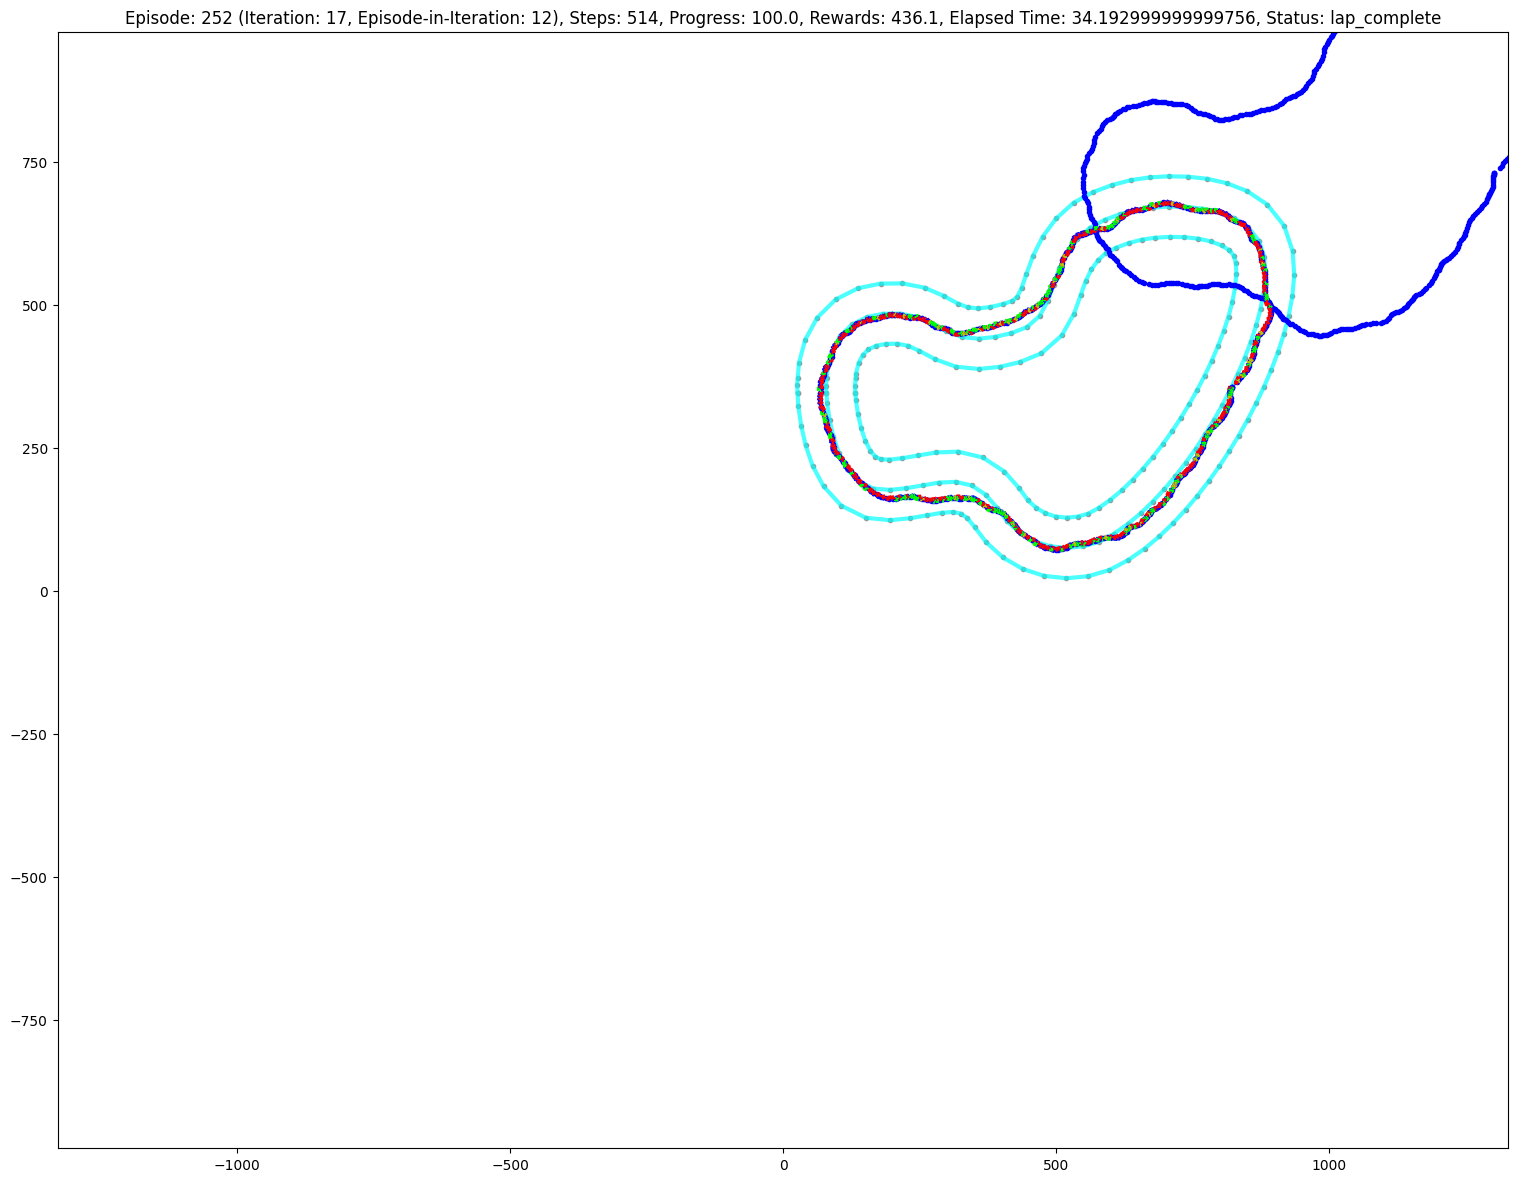

In [70]:
if episode_sim_df_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(episode_sim_df_fastest_full_lap['episode'].values, 
                        len(episode_sim_df_fastest_full_lap), 
                        x_offset, 
                        y_offset, 
                        True, 
                        True)
    
    # Zoom in for better look
    for ax in fig.get_axes():
        episode_id = episode_sim_df_fastest_full_lap['episode'].values[0]
        episode_data = sim_df[sim_df['episode'] == episode_id]
        min_x, max_x = episode_data['x'].min(), episode_data['x'].max()
        min_y, max_y = episode_data['y'].min(), episode_data['y'].max()
        
        x_range = max_x - min_x
        y_range = max_y - min_y

        margin_x = 1.11 * x_range
        margin_y = 1.11 * y_range

        ax.set_xlim([min_x - margin_x, max_x + margin_x])
        ax.set_ylim([min_y - margin_y, max_y + margin_y])

    episode_data_dict = episode_data.to_dict(orient='records')

    # Upload to Firebase
    model_name = json_parameters.get('/MODEL_NAME', 'default_collection')
    doc_ref = db.collection(model_name).document('racing_line_arrows').set({'data': episode_data_dict})

# Blue is the HEADING of the car
# Green shows that the car is turning left
# Yellow shows that the car is driving straight
# Red shows that the car is turning right
# The length of each arrow indicates the relative speed of the car


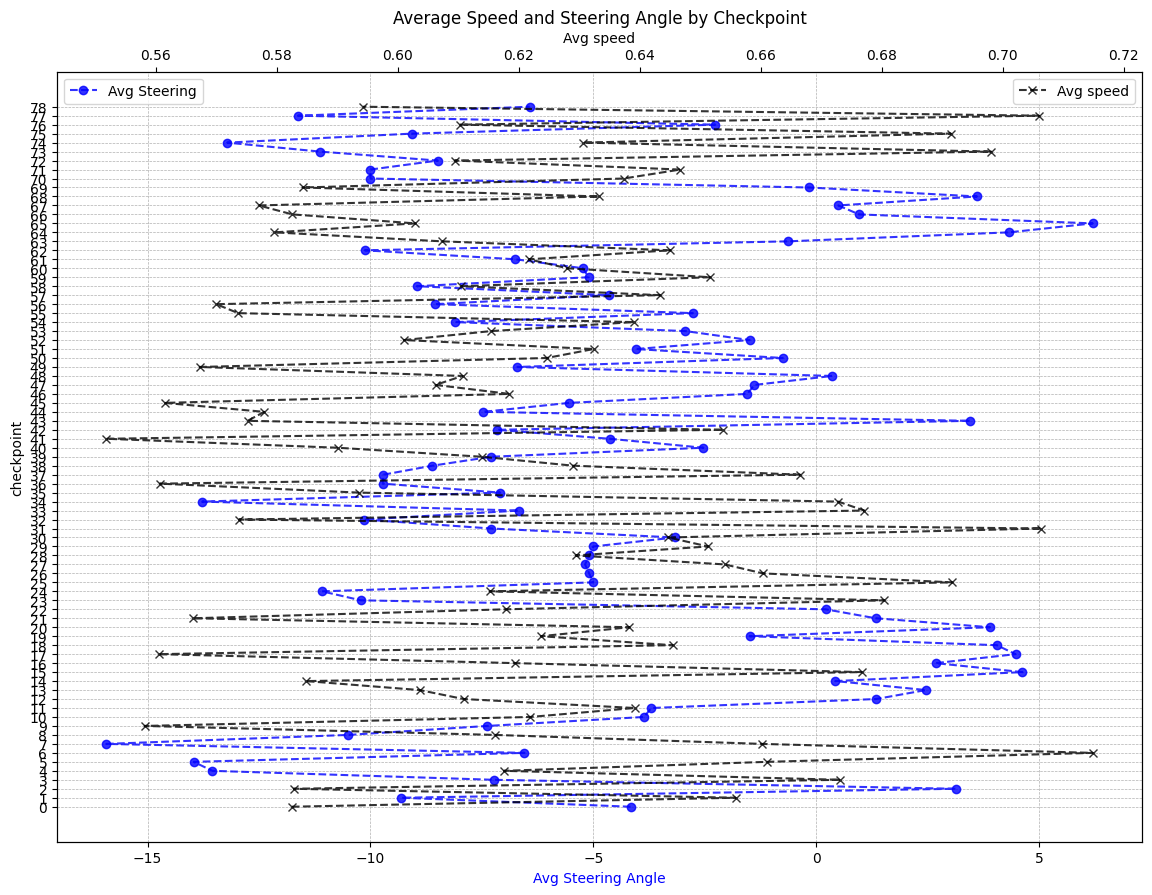

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_avg_speed_steering(df):
    # Group data by checkpoint and calculate mean
    grouped_df = df.groupby('closest_checkpoint').agg({'steer': 'mean', 'speed': 'mean'}).reset_index()

    # Create a plot
    fig, ax1 = plt.subplots(figsize=(14, 10))
    ax2 = ax1.twiny()

    ax1.plot(grouped_df['steer'], grouped_df['closest_checkpoint'], color='blue', label='Avg Steering', linestyle='--', marker='o', alpha=0.8)
    ax2.plot(grouped_df['speed'], grouped_df['closest_checkpoint'], color='black', label='Avg speed', linestyle='--', marker='x', alpha=0.8)

    ax1.set_xlabel('Avg Steering Angle', color='b')
    ax2.set_xlabel('Avg speed', color='black')
    ax1.set_ylabel('checkpoint')
    ax1.set_yticks(grouped_df['closest_checkpoint'])
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title("Average Speed and Steering Angle by Checkpoint")
    
    plt.show()

    processed_data_dict = grouped_df.to_dict(orient='records')
    model_name = json_parameters.get('/MODEL_NAME', 'default_collection')
    doc_ref = db.collection(model_name).document('avg_speed_steering').set({'data': processed_data_dict})


max_iteration = sim_df['iteration'].max()
plot_avg_speed_steering(sim_df[sim_df['iteration'] == max_iteration])
